## Beispiel Implementierung

Fuer ein 2-layer Netzwerk zur Klassifizierung der Pinguine.

### Setup

Wir importieren die ben&ouml;tigten Module und laden die Daten.

In [1]:
# import the required modules
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import approx_fprime  # we will use this function to compute gradients

# load the data
with open('penguin-data.json', 'r') as f:
    datadict = json.load(f)
# turn it into a numpy array
data = np.array(datadict['data'])
data = data - data.mean(axis=0)
# extract the labels
lbls = np.array(datadict['target'])

In diesem Beispiel unterscheiden wir nur zwei Gruppen. Wir teilen die
ersetzen die eigentlichen *labels* `[0, 1, 2]` durch die zwei *lables* `[-1,
1]`.

In [17]:
# a dictionary that maps the labels(=targets) of the data into labels {1, -1}
# that will use for distinction of two groups
mplbldict = {0: np.array([1]),
             1: np.array([1]),
             2: np.array([-1])}
print('our two groups: \n', [f'{datadict["target_names"][lblid]} --> {mplbldict[lblid].item()}' for lblid in [0, 1, 2]])

our two groups: 
 ['Adelie --> 1', 'Gentoo --> 1', 'Chinstrap --> -1']


Als n&auml;chstes legen wir die Dimensionen der *layers* fest und damit auch die
Gr&ouml;&szlig;e der Gewichtsmatrizen. Bei unserem 2-layer Netzwerk, bleibt uns
da nur die Gr&ouml;&szlig;e der mittleren Schicht, da die Eingangsdimension
durch die Daten und die Ausgangsdimension durch unsere Wahl, wie wir entscheiden
wollen, bereits festgelegt ist.

In [3]:
# sizes of the layers
sxz, sxo, sxt = data.shape[1], 2, mplbldict[0].size
# defines also the sizes of the weightmatrices

Zuletzt noch die Parameter, die das *training* definieren. 

* `batchsize` -- &uuml;ber wieviele Samples wird der stochastische Gradient
  bestimmt
* `lr` -- *learning rate* -- die Schrittweite
* `epochs` -- wie oft wird &uuml;ber die Daten iteriert

und dann wie gross der Anteil und was die Indizes der Trainings--
beziehungsweise Testdaten sind

In [4]:
# parameters for the training -- these worked fine for me
batchsize = 30  # how many samples for the stochastic gradients
lr = 0.125  # learning rate
epochs = 1000  # how many gradient steps

# the data
traindataratio = .9     # the ratio of training data vs. test data
ndata = data.shape[0]   # number of datapoints                                       
trnds = int(ndata*traindataratio)
allidx = np.arange(ndata)                                   # indices of all data
trnidx = np.random.choice(allidx, trnds, replace=False)     # training ids
tstidx = np.setdiff1d(allidx, trnidx)                       # test ids

### Neural Network Evaluation Setup

Hier definieren wir das Netzwerk als Funktion der Parameter und die *loss function*, die misst wie gut das Netzwerk die Daten wiedergibt und die Grundlage fuer die Optimierung ist.


In [ ]:
def fwdnn(xzero, Aone=None, bone=None, Atwo=None, btwo=None):
    ''' definition/(forward)evaluation of a neural networks of two layers

    '''
    xone = np.tanh(Aone @ xzero + bone)
    xtwo = np.tanh(Atwo @ xone + btwo)
    return xtwo

In [ ]:
def sqrdloss(weightsvector, features=None, labels=None):
    ''' compute the sqrd `loss`

    || NN(x_i) - y_i ||^2

    given the vector of weights for a given data point (features)
    and the corresponding label
    '''

    Aone, bone, Atwo, btwo = wvec_to_wmats(weightsvector)
    # compute the prediction
    nnpred = fwdnn(features, Aone=Aone, bone=bone, Atwo=Atwo, btwo=btwo)
    return np.linalg.norm(nnpred - labels)**2

An sich liegen die Parameter als Matrizen vor. Da jedoch die Theorie (und auch die praktische Implementierung) einen Parameter**vektor** voraussetzt, entrollen wir die Matrizen und stecken sie in einen grossen Vektor. Dann muessen wir noch an der richtigen Stelle wieder die Matrizen aus dem Vektor extrahieren; was die folgende Funktion realisiert.

In [ ]:
def wvec_to_wmats(wvec):
    ''' helper to turn the vector of weights into the system matrices

    '''
    Aone = wvec[:sxz*sxo].reshape((sxo, sxz))
    cidx = sxz*sxo
    bone = wvec[cidx:cidx+sxo]
    cidx = cidx + sxo
    Atwo = wvec[cidx:cidx+sxo*sxt].reshape((sxt, sxo))
    cidx = cidx + sxo*sxt
    btwo = wvec[cidx:]
    if Aone.size + bone.size + Atwo.size + btwo.size == wvec.size:
        return Aone, bone, Atwo, btwo
    else:
        raise UserWarning('mismatch weightsvector/matrices')

### Das Training

Der Parametervektor ("die Gewichte") werden zufaellig initialisiert und dann mit dem stochastischen Gradienten in mehreren Epochen optimiert.

In [11]:
# initialization of the weights
wini = np.random.randn(sxo*sxz + sxo + sxt*sxo + sxt)
gradnrml = []  # list of norm of grads for plotting later

cwghts = wini  # the current state of the weight vector
for kkk in range(epochs):
    cids = np.random.choice(trnidx, batchsize, replace=False)
    cgrad = np.zeros(wini.shape)
    for cid in cids:
        itrgts = data[cid, :]
        ilabls = mplbldict[lbls[cid]]
        cgrad = cgrad + approx_fprime(cwghts, sqrdloss, 1e-8,
                                      itrgts, ilabls)
    cwghts = cwghts - lr*1/batchsize*cgrad  # the upgrade
    gradnrml.append(1/batchsize*np.linalg.norm(cgrad))
    if np.mod(kkk, 50) == 0:
        print(f'k={kkk}: norm of gradient: {np.linalg.norm(cgrad)}')

k=0: norm of gradient: 62.08036334209341
k=50: norm of gradient: 4.590950817400852
k=100: norm of gradient: 6.7776589732579975
k=150: norm of gradient: 3.06227920557032
k=200: norm of gradient: 1.5537732318941215
k=250: norm of gradient: 11.0694947241319
k=300: norm of gradient: 38.72138030931918
k=350: norm of gradient: 21.41231864875493
k=400: norm of gradient: 5.368028489385387
k=450: norm of gradient: 1.350642409160792
k=500: norm of gradient: 36.51200168257528
k=550: norm of gradient: 0.44500113601203634
k=600: norm of gradient: 7.280991950031262
k=650: norm of gradient: 0.881598577100325
k=700: norm of gradient: 84.03194425810652
k=750: norm of gradient: 0.351806084902731
k=800: norm of gradient: 12.435123186242874
k=850: norm of gradient: 3.0028421931471136
k=900: norm of gradient: 0.41013909100357
k=950: norm of gradient: 13.28238866308735


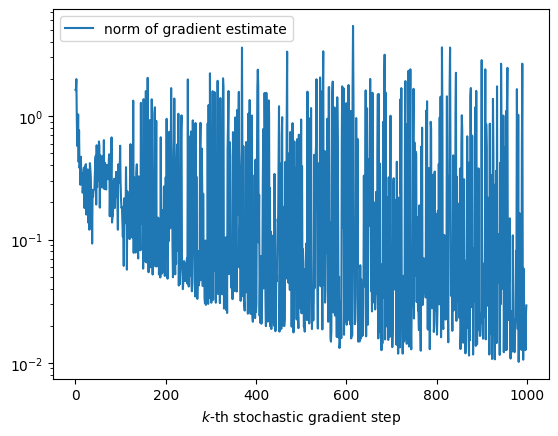

In [6]:
plt.figure()
plt.semilogy(gradnrml, label='norm of gradient estimate')
plt.xlabel('$k$-th stochastic gradient step')
plt.legend()
plt.show()

Wir koennen eine gewisse Konvergenz beobachten (sichtbar an der unteren Kante) aber auch ein typisches stochastisches Verhalten.

### Das Auswerten

Wir nehmen das Ergebnis der letzten Iteration als *beste Parameter*, definieren damit das Neuronale Netz, und testen auf den uebriggebliebenen Daten das Ergebnis.

In [7]:
optwghts = cwghts  # the optimal weights

In [8]:
Aonex, bonex, Atwox, btwox = wvec_to_wmats(optwghts)

In [9]:
print('***** testing the classification *****')
faillst = []
for cti in tstidx:  # iteration over the test data points
    itrgt = data[cti, :]
    ilbl = mplbldict[lbls[cti]]
    # the prediction of the neural network
    nnlbl = fwdnn(itrgt, Aone=Aonex, bone=bonex, Atwo=Atwox, btwo=btwox)
    sccs = np.sign(ilbl) == np.sign(nnlbl)
    print(f'label: {ilbl.item()} -- nn: {nnlbl.item():.4f} -- success: {sccs}')
    if not sccs:
        faillst.append((cti, ilbl.item(), nnlbl.item(),
                        datadict['target_names'][lbls[cti]]))
    else:
        pass

***** testing the classification *****
label: 1 -- nn: 0.9437 -- success: [ True]
label: 1 -- nn: 0.9437 -- success: [ True]
label: 1 -- nn: 0.9437 -- success: [ True]
label: 1 -- nn: 0.9437 -- success: [ True]
label: 1 -- nn: 0.9437 -- success: [ True]
label: 1 -- nn: 0.9437 -- success: [ True]
label: 1 -- nn: 0.9437 -- success: [ True]
label: 1 -- nn: 0.9437 -- success: [ True]
label: 1 -- nn: 0.9999 -- success: [ True]
label: 1 -- nn: 0.9998 -- success: [ True]
label: 1 -- nn: 0.9999 -- success: [ True]
label: 1 -- nn: 0.9189 -- success: [ True]
label: 1 -- nn: 0.9189 -- success: [ True]
label: 1 -- nn: 0.9189 -- success: [ True]
label: 1 -- nn: 0.9189 -- success: [ True]
label: 1 -- nn: 0.9189 -- success: [ True]
label: 1 -- nn: 0.9191 -- success: [ True]
label: 1 -- nn: 0.9189 -- success: [ True]
label: 1 -- nn: 0.9189 -- success: [ True]
label: 1 -- nn: 0.9189 -- success: [ True]
label: 1 -- nn: 0.9189 -- success: [ True]
label: 1 -- nn: 0.9189 -- success: [ True]
label: 1 -- nn:

In [10]:
print('\n***** Results *****')
print(f'{100-len(faillst)/tstidx.size*100:.0f}% was classified correctly')
print('***** Misses *****')
if len(faillst) == 0:
    print('None')
else:
    for cfl in faillst:
        cid, lbl, nnlbl, name = cfl
        print(f'ID: {cid} ({name} pinguin) was missclassified ' +
              f'with score {nnlbl:.4f} vs. {lbl}')


***** Results *****
97% was classified correctly
***** Misses *****
ID: 282 (Chinstrap pinguin) was missclassified with score 0.5442 vs. -1
